In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from statsmodels import api as sm

from ucimlrepo import fetch_ucirepo

import warnings
warnings.filterwarnings('ignore')

In [2]:
student_performance = fetch_ucirepo(id=162)

X = student_performance.data.features
y = student_performance.data.targets

df = pd.concat([X, y], axis=1)

In [3]:
# variable information 
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
dtypes: float64(7), int64(3), object(2)
memory usage: 48.6+ KB


In [5]:
# Separate categorical and numerical features
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [6]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first'), cat_cols)
])

X_processed = preprocessor.fit_transform(X)

In [7]:
# 1. Get numeric column names (unchanged by StandardScaler)
num_features = num_cols

# 2. Get categorical feature names (after OneHotEncoder)
cat_transformer = preprocessor.named_transformers_['cat']
cat_feature_names = cat_transformer.get_feature_names_out(cat_cols)

# 3. Combine them
feature_names = list(num_features) + list(cat_feature_names)

# 4. Transform X and convert to DataFrame
X_processed = preprocessor.transform(X)
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)

In [8]:
X_processed_df.shape

(517, 27)

In [9]:
X_processed_df

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_may,month_nov,month_oct,month_sep,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,1.008313,0.569860,-0.805959,-1.323326,-1.830477,-0.860946,-1.842640,0.411724,1.498614,-0.073268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.008313,-0.244001,-0.008102,-1.179541,0.488891,-0.509688,-0.153278,-0.692456,-1.741756,-0.073268,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.008313,-0.244001,-0.008102,-1.049822,0.560715,-0.509688,-0.739383,-0.692456,-1.518282,-0.073268,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.440925,1.383722,0.191362,-1.212361,-1.898266,-0.004756,-1.825402,3.233519,-0.009834,0.603155,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.440925,1.383722,-0.243833,-0.931043,-1.798600,0.126966,-1.291012,3.356206,-1.238940,-0.073268,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,-0.289524,-1.057862,-1.640083,-0.846648,0.474768,-1.563460,1.536084,-0.753800,-0.736124,-0.073268,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
513,-1.154748,-0.244001,-1.640083,-0.846648,0.474768,-1.563460,0.519019,1.638592,0.995798,-0.073268,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
514,1.008313,-0.244001,-1.640083,-0.846648,0.474768,-1.563460,0.398350,1.577248,1.498614,-0.073268,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
515,-1.587360,-0.244001,0.680957,0.549003,0.269382,0.500176,1.156839,-0.140366,-0.009834,-0.073268,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [10]:
model = LinearRegression()
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# **Forward Selection**

In [11]:
sfs_forward = SFS(model,
          k_features=(1,len(X_processed_df.columns)), # Number of features to select
          forward=True,   # Forward selection
          floating=False, # No floating
          scoring='neg_mean_squared_error',  # Scoring metric
          n_jobs=-1, # Use all processors
          cv=cv)           # Cross-validation folds

In [12]:
sfs_forward = sfs_forward.fit(X_processed_df, y)

In [13]:
results_forward = pd.DataFrame.from_dict(sfs_forward.get_metric_dict()).T
results_forward['num_features'] = results_forward.index.astype(int)
results_forward

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,num_features
1,"(6,)","[-22428.214466650603, -1080.8712299144368, -29...",-4034.346719,"(temp,)",5143.792683,6925.680612,2308.560204,1
2,"(0, 6)","[-22348.982146826518, -1197.0965081995657, -30...",-4025.580524,"(X, temp)",5116.418141,6888.823114,2296.274371,2
3,"(0, 6, 11)","[-22326.93013347416, -1190.0423105265745, -298...",-4020.641845,"(X, temp, month_dec)",5110.756128,6881.199692,2293.733231,3
4,"(0, 6, 11, 15)","[-22305.09610564031, -1187.5419864740568, -310...",-4019.139831,"(X, temp, month_dec, month_jun)",5103.268804,6871.118646,2290.372882,4
5,"(0, 6, 11, 15, 19)","[-22299.99883134533, -1184.667798367938, -315....",-4018.165844,"(X, temp, month_dec, month_jun, month_oct)",5102.679006,6870.324533,2290.108178,5
6,"(0, 6, 11, 12, 15, 19)","[-22298.979468836995, -1181.9805146437382, -31...",-4017.738606,"(X, temp, month_dec, month_feb, month_jun, mon...",5102.260687,6869.761303,2289.920434,6
7,"(0, 6, 11, 12, 15, 18, 19)","[-22298.953771840894, -1182.1641683062974, -31...",-4017.754073,"(X, temp, month_dec, month_feb, month_jun, mon...",5102.249594,6869.746366,2289.915455,7
8,"(0, 6, 11, 12, 13, 15, 18, 19)","[-22297.421466994398, -1179.965562557287, -314...",-4017.819432,"(X, temp, month_dec, month_feb, month_jan, mon...",5101.704015,6869.011791,2289.670597,8
9,"(0, 6, 8, 11, 12, 13, 15, 18, 19)","[-22278.495142213284, -1190.88957452402, -326....",-4019.155536,"(X, temp, wind, month_dec, month_feb, month_ja...",5094.83151,6859.758545,2286.586182,9
10,"(0, 6, 8, 11, 12, 13, 15, 16, 18, 19)","[-22281.908236061823, -1189.12546189808, -328....",-4020.196492,"(X, temp, wind, month_dec, month_feb, month_ja...",5096.215201,6861.621569,2287.20719,10


In [14]:
highest_avg_score = results_forward['avg_score'].max()
best_model_forward = results_forward[results_forward['avg_score'] == highest_avg_score]
print(f"Best model: {best_model_forward['num_features'].values[0]} \nFeatures with an average negarive mean squared score of {highest_avg_score:.4f}")
print(f"Features: {best_model_forward['feature_names'].values[0]}")

Best model: 15 
Features with an average negarive mean squared score of -4016.9240
Features: ('X', 'FFMC', 'DMC', 'DC', 'temp', 'RH', 'wind', 'month_dec', 'month_feb', 'month_jan', 'month_jun', 'month_mar', 'month_nov', 'month_oct', 'month_sep')


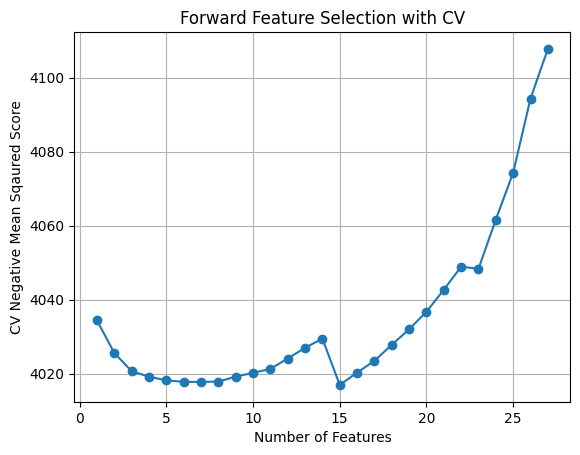

In [31]:
# Plot
plt.plot(results_forward['num_features'], results_forward['avg_score'] * -1, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('CV Negative Mean Sqaured Score')
plt.title('Forward Feature Selection with CV')
plt.grid(True)
plt.show()

# **Backward Elimination**

In [16]:
sfs_backward = SFS(model,
          k_features=(1,len(X_processed_df.columns)), # Number of features to select
          forward=False,   # Forward selection
          floating=False, # No floating
          scoring='neg_mean_squared_error',  # Scoring metric
          n_jobs=-1, # Use all processors
          cv=cv)           # Cross-validation folds

In [17]:
sfs_backward = sfs_backward.fit(X_processed_df, y)

In [18]:
results_backward = pd.DataFrame.from_dict(sfs_backward.get_metric_dict()).T
results_backward['num_features'] = results_backward.index.astype(int)
results_backward

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,num_features
27,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-21992.596064847603, -1273.9462394928828, -39...",-4107.748175,"(X, Y, FFMC, DMC, DC, ISI, temp, RH, wind, rai...",5034.539558,6778.580545,2259.526848,27
26,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-21990.130557463675, -1263.6025678216215, -39...",-4094.328715,"(X, Y, FFMC, DMC, DC, ISI, temp, RH, wind, rai...",5035.834084,6780.323514,2260.107838,26
25,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-22046.52027500194, -1231.4859273341356, -355...",-4074.298287,"(X, Y, FFMC, DMC, DC, ISI, temp, RH, wind, rai...",5026.392589,6767.611342,2255.870447,25
24,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...","[-22046.620091575485, -1234.0115768397868, -35...",-4061.627052,"(X, Y, FFMC, DMC, DC, ISI, temp, RH, wind, mon...",5031.022503,6773.845129,2257.948376,24
23,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...","[-22028.383598966924, -1185.4892052011755, -35...",-4048.313245,"(X, Y, FFMC, DMC, DC, ISI, temp, RH, wind, mon...",5027.874924,6769.607181,2256.535727,23
22,"(0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 1...","[-22052.91157285554, -1164.394173493805, -357....",-4042.537703,"(X, Y, FFMC, DMC, DC, temp, RH, wind, month_au...",5027.245076,6768.759144,2256.253048,22
21,"(0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 1...","[-22054.217460380038, -1164.5108683017277, -33...",-4037.451873,"(X, Y, FFMC, DMC, DC, temp, RH, wind, month_au...",5029.880245,6772.307175,2257.435725,21
20,"(0, 2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 15, ...","[-22052.804669917452, -1164.106508407699, -334...",-4033.799392,"(X, FFMC, DMC, DC, temp, RH, wind, month_aug, ...",5030.619151,6773.30205,2257.76735,20
19,"(0, 2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 15, ...","[-22054.11968825606, -1166.71904308587, -337.3...",-4030.652963,"(X, FFMC, DMC, DC, temp, RH, wind, month_aug, ...",5031.305963,6774.226783,2258.075594,19
18,"(0, 2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 15, ...","[-22059.45066461339, -1160.4069639067436, -339...",-4028.425925,"(X, FFMC, DMC, DC, temp, RH, wind, month_aug, ...",5034.285907,6778.239026,2259.413009,18


In [19]:
highest_avg_score = results_backward['avg_score'].max()
best_model_backward = results_backward[results_backward['avg_score'] == highest_avg_score]
print(f"Best model: {best_model_backward['num_features'].values[0]} \nFeatures with an average negative mean squared score of {highest_avg_score:.4f}")
print(f"Features: {best_model_backward['feature_names'].values[0]}")

Best model: 11 
Features with an average negative mean squared score of -4008.8248
Features: ('X', 'DMC', 'DC', 'temp', 'wind', 'month_dec', 'month_jun', 'month_mar', 'month_nov', 'month_oct', 'month_sep')


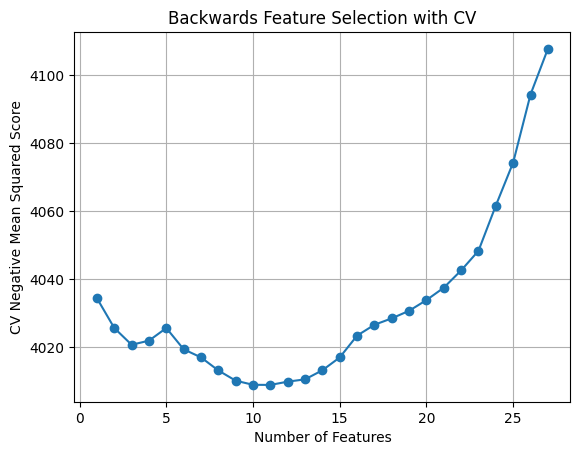

In [30]:
# Plot
plt.plot(results_backward['num_features'], results_backward['avg_score'] * -1, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('CV Negative Mean Squared Score')
plt.title('Backwards Feature Selection with CV')
plt.grid(True)
plt.show()

# **Stepwise Regression**

In [21]:
sfs_stepwise = SFS(model,
          k_features=(1,len(X_processed_df.columns)), # Number of features to select
          forward=True,   # Forward selection
          floating=True, # No floating
          scoring='neg_mean_squared_error',  # Scoring metric
          n_jobs=-1, # Use all processors
          cv=cv)           # Cross-validation folds

In [22]:
sfs_stepwise = sfs_stepwise.fit(X_processed_df, y)

In [23]:
results_stepwise = pd.DataFrame.from_dict(sfs_stepwise.get_metric_dict()).T
results_stepwise['num_features'] = results_stepwise.index.astype(int)
results_stepwise

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,num_features
1,"(6,)","[-22428.214466650603, -1080.8712299144368, -29...",-4034.346719,"(temp,)",5143.792683,6925.680612,2308.560204,1
2,"(0, 6)","[-22348.982146826518, -1197.0965081995657, -30...",-4025.580524,"(X, temp)",5116.418141,6888.823114,2296.274371,2
3,"(0, 6, 11)","[-22326.93013347416, -1190.0423105265745, -298...",-4020.641845,"(X, temp, month_dec)",5110.756128,6881.199692,2293.733231,3
4,"(0, 6, 11, 15)","[-22305.09610564031, -1187.5419864740568, -310...",-4019.139831,"(X, temp, month_dec, month_jun)",5103.268804,6871.118646,2290.372882,4
5,"(0, 6, 11, 15, 19)","[-22299.99883134533, -1184.667798367938, -315....",-4018.165844,"(X, temp, month_dec, month_jun, month_oct)",5102.679006,6870.324533,2290.108178,5
6,"(0, 6, 11, 12, 15, 19)","[-22298.979468836995, -1181.9805146437382, -31...",-4017.738606,"(X, temp, month_dec, month_feb, month_jun, mon...",5102.260687,6869.761303,2289.920434,6
7,"(0, 6, 11, 12, 15, 18, 19)","[-22298.953771840894, -1182.1641683062974, -31...",-4017.754073,"(X, temp, month_dec, month_feb, month_jun, mon...",5102.249594,6869.746366,2289.915455,7
8,"(0, 6, 11, 12, 13, 15, 18, 19)","[-22297.421466994398, -1179.965562557287, -314...",-4017.819432,"(X, temp, month_dec, month_feb, month_jan, mon...",5101.704015,6869.011791,2289.670597,8
9,"(0, 6, 8, 11, 12, 13, 15, 18, 19)","[-22278.495142213284, -1190.88957452402, -326....",-4019.155536,"(X, temp, wind, month_dec, month_feb, month_ja...",5094.83151,6859.758545,2286.586182,9
10,"(0, 6, 8, 11, 12, 13, 15, 16, 18, 19)","[-22281.908236061823, -1189.12546189808, -328....",-4020.196492,"(X, temp, wind, month_dec, month_feb, month_ja...",5096.215201,6861.621569,2287.20719,10


In [24]:
highest_avg_score = results_stepwise['avg_score'].max()
best_model_stepwise = results_stepwise[results_stepwise['avg_score'] == highest_avg_score]
print(f"Best model: {best_model_stepwise['num_features'].values[0]} \nFeatures with an average neagtive mean square error score of {highest_avg_score:.4f}")
print(f"Features: {best_model_stepwise['feature_names'].values[0]}")

Best model: 11 
Features with an average neagtive mean square error score of -4008.8248
Features: ('X', 'DMC', 'DC', 'temp', 'wind', 'month_dec', 'month_jun', 'month_mar', 'month_nov', 'month_oct', 'month_sep')


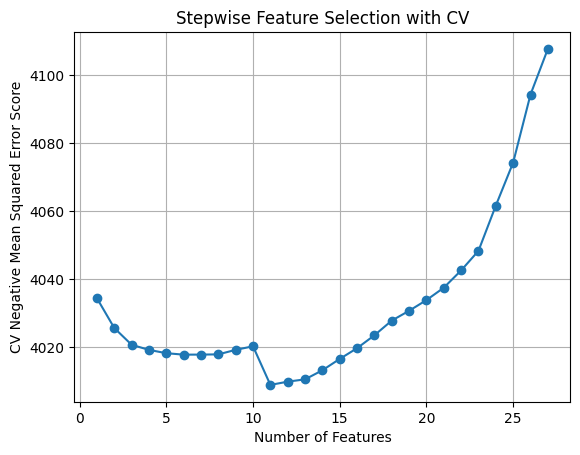

In [29]:
# Plot
plt.plot(results_stepwise['num_features'], results_stepwise['avg_score'] * -1, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('CV Negative Mean Squared Error Score')
plt.title('Stepwise Feature Selection with CV')
plt.grid(True)
plt.show()

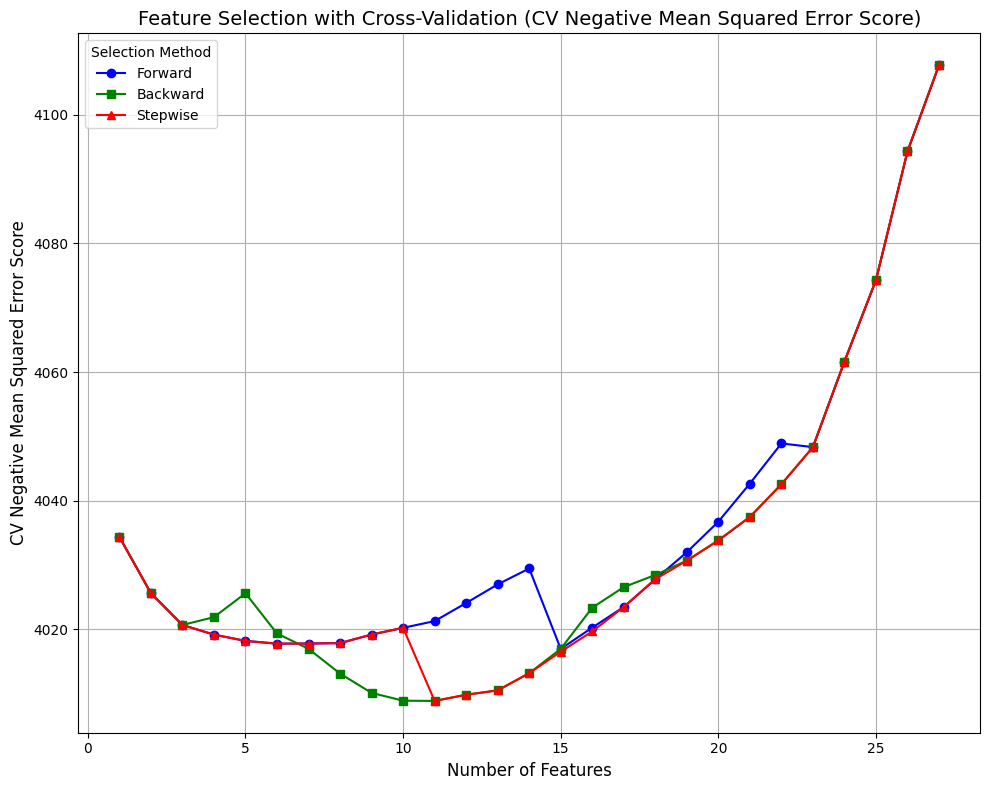

In [32]:
plt.figure(figsize=(10, 8))
plt.title('Feature Selection with Cross-Validation (CV Negative Mean Squared Error Score)', fontsize=14)

# Plot each selection method
plt.plot(results_forward['num_features'], results_forward['avg_score'] * -1, marker='o', label='Forward', color='blue')
plt.plot(results_backward['num_features'], results_backward['avg_score'] * -1, marker='s', label='Backward', color='green')
plt.plot(results_stepwise['num_features'], results_stepwise['avg_score'] * -1, marker='^', label='Stepwise', color='red')

# Labels and formatting
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('CV Negative Mean Squared Error Score', fontsize=12)
plt.legend(title='Selection Method')
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
def processSubset(feature_set, X_train, y_train, X_test, y_test):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y_train,X_train[list(feature_set)].astype(float))
    regr = model.fit()
    RSS = ((regr.predict(X_test[list(feature_set)]) - y_test) ** 2).sum()
    summary = regr.summary()
    return {"model":regr, "RSS":RSS, "summary":summary, "features":feature_set} # Return model, RSS, and summary

In [28]:
# Forward Best Model Refit
X_train, X_test, y_train, y_test = train_test_split(X_processed_df[list(best_model_forward['feature_names'].values[0])], y, test_size=0.3, random_state=42)
forward_model = processSubset(best_model_forward['feature_names'].values[0], X_train, y_train, X_test, y_test)
print(f"Forward Best Model RSS: {forward_model['RSS']:.4f}")
print(f"Forward Best Model Number of Features: {len(forward_model['features'])}")
print(forward_model['summary'])


TypeError: unsupported format string passed to Series.__format__

In [ ]:
# Backward Best Model Refit
X_train, X_test, y_train, y_test = train_test_split(X_processed_df[list(best_model_backward['feature_names'].values[0])], y, test_size=0.3, random_state=42)
backward_model = processSubset(best_model_backward['feature_names'].values[0], X_train, y_train, X_test, y_test)
print(f"Backward Best Model RSS: {backward_model['RSS']:.4f}")
print(f"Backward Best Model Number of Features: {len(backward_model['features'])}")
print(backward_model['summary'])


TypeError: unsupported format string passed to Series.__format__

In [ ]:
# Step-wise Best Model Refit
X_train, X_test, y_train, y_test = train_test_split(X_processed_df[list(best_model_stepwise['feature_names'].values[0])], y, test_size=0.3, random_state=42)
stepwise_model = processSubset(best_model_stepwise['feature_names'].values[0], X_train, y_train, X_test, y_test)
print(f"Stepwise Best Model RSS: {stepwise_model['RSS']:.4f}")
print(f"Stepwise Best Model Number of Features: {len(stepwise_model['features'])}")
print(stepwise_model['summary'])


TypeError: unsupported format string passed to Series.__format__